In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import math
import random
from nltk.tokenize import TweetTokenizer,RegexpTokenizer,word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from string import punctuation
import re
import seaborn as sns
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import plot_confusion_matrix
import pickle
import emot
import contractions

In [91]:
def init():
    train = pd.read_csv("data/train.csv",encoding="iso-8859-1",header=None)
    test = pd.read_csv("data/test.csv",encoding="iso-8859-1",header=None)
    return train,test

In [92]:
train,test = init()

# A

In [93]:
train.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [94]:
train4 = train[train[0]==4]
train0 = train[train[0]==0]
len(train4[5].unique())

793506

In [95]:
# Pass data,column of text
def getVocab(train,col):
    vocab = {}
    count=0
#     data = []
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
        words = data[i].replace("."," ").split(" ")
#         words = data[i].split(" ")
        if " " in words:
            words.remove(" ")
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
#             x.append(j)
#                 x.append(vocab[j])
#         data.append(x)
#     train[1]=data
    return vocab

In [96]:
st = time()
vocab = getVocab(train,5)
print(time()-st)

4.49056077003479


In [97]:
len(vocab)

1133910

In [98]:
# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
#         total=total+len(i.split(" "))
        words = i.replace("."," ").split(" ")
#         words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+len(words)
        for j in words:
            v[j] = v[j]+1
    for key in v:
        v[key] = float(v[key]/total)
    return v,total
    
def learnParam(train,vocab,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
    phi4 = (len(train4[col].unique()))/(m)
#     phi0 = (train[train[0]==0].shape[0]+1)/(m+2)
#     phi2 = (train[train[0]==2].shape[0]+1)/m
#     phi4 = (train[train[0]==4].shape[0]+1)/(m+2)
    param0,t0 = findParamVocab(train[train[0]==0],vocab,col)
#     param2,t2 = findParamVocab(train[train[0]==2],vocab,col)
    param4,t4 = findParamVocab(train[train[0]==4],vocab,col)
#     return phi0,phi2,phi4,param0,param2,param4,t0,t2,t4
    return phi0,phi4,param0,param4,t0,t4

In [99]:
st = time()
phi0,phi4,theta0,theta4,t0,t4 = learnParam(train,vocab,5)
print(time()-st)

8.892055749893188


In [100]:
# Pass the column of text
# def findClasses(data,phi0,phi1,phi2,theta0,theta2,theta4,t0,t2,t4):
def findClasses(data,phi0,phi4,theta0,theta4,t0,t4):
    pred = []
    pred0 = []
    pred4 = []
    for i in data:
        prob0 = 0
        prob2 = 0
        prob4 = 0
        words = i.split(" ")
        if " " in words:
            words.remove(" ")
        for j  in words:
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
                
#             if(j in theta2):
#             try:
#                 prob2 = prob2+(math.log(theta2[j]))
#             except:
#                 prob2 = prob2+float(1/(t2+1))
                
#             if(j in theta4):
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
                
        prob0 = prob0+(math.log(phi0))
#         prob2 = prob2+(math.log(phi2))
        prob4 = prob4+(math.log(phi4))
        if(prob0>prob4):
            pred.append(0)
#         elif(prob2>prob0 and prob2>prob4):
#             pred.append(2)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

In [101]:
st = time()
# predictionTrain = findClasses(train[5],phi0,phi2,phi4,theta0,theta2,theta4,t0,t2,t4)
predictionTrain,pred0,pred4 = findClasses(train[5],phi0,phi4,theta0,theta4,t0,t4)
print(time()-st)

15.139131546020508


In [102]:
check = (train[0]==predictionTrain)

In [103]:
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.845434375


In [104]:
st = time()
test = test[test[0]==0].append(test[test[0]==4])
predictionTest,predTest0,predTest4 = findClasses(test[5],phi0,phi4,theta0,theta4,t0,t4)
print(time()-st)

0.00608372688293457


In [105]:
check = (test[0]==predictionTest)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.8050139275766016


# B

In [106]:
def randomGuess(data):
    choices=[0,4]
    pred=[]
    for i in data:
        pred.append(random.choice(choices))
    return pred

In [107]:
st = time()
predictionRandom = randomGuess(test[5])
print(time()-st)

0.02212381362915039


In [108]:
check = (test[0]==predictionRandom)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.5292479108635098


In [109]:
def majorityGuess(train,test):
    c0 = train[train[0]==0][5].unique().shape[0]
#     c2 = train[train[0]==2].shape[0]
    c4 = train[train[0]==4][5].unique().shape[0]
    m=0
    if(c0>c4):
        m=0
#     elif(c2>c0 and c2>c4):
#         m=2
    else:
        m=4
        
    pred=[]
    for i in test[5]:
        pred.append(m)
    return pred

In [110]:
st = time()
predictionMajority = majorityGuess(train,test)
print(time()-st)

0.5130472183227539


In [111]:
check = (test[0]==predictionMajority)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.5069637883008357


# C

In [112]:
def confusionMatrix(test,prediction):
    mat = np.zeros((2,2))
    index=0
    for i in test[0]:
        mat[int(i/4)][int(prediction[index]/4)] = mat[int(i/4)][int(prediction[index]/4)]+1
        index=index+1
    return mat

In [113]:
matrix = confusionMatrix(test,predictionTest)
matrix

array([[144.,  33.],
       [ 37., 145.]])

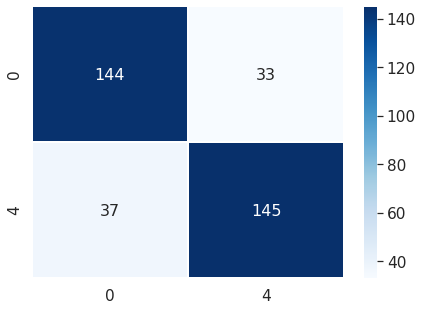

In [114]:
def drawMatrix(matrix):
    df_cm = pd.DataFrame(matrix.astype(int), index = [i for i in "04"],
                      columns = [i for i in "04"])
    plt.figure(figsize = (7,5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm,cmap="Blues", annot=True,fmt="d",linewidth=1,annot_kws={"size": 16})
    plt.show()
    
drawMatrix(matrix)

# D

In [115]:
stemmer = PorterStemmer()
# stemmer = SnowballStemmer("english")
# tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
# tokenizer = RegexpTokenizer(r'[A-Za-z0-9]+')
# tokenizer = RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'))

In [116]:
s = "@stustone Your show is whack. Way worse than whack, it's wiggety-whack.    :*(:*(:*("
t = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D "
# t = t.replace("."," ")
s = contractions.fix(s.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
s = " ".join([stemmer.stem(j) for j in s if (stemmer.stem(j) not in stop and '@' not in j)])
emot.emoticons(s)['value']
# [stemmer.stem(j) for j in contractions.fix(t).split(" ") if (j not in stop and j not in punctuation and '@' not in j)] 


[':*', ':*', ':*']

In [117]:
# just pass the whole data
# 81.89 = words = contractions.fix(i).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
# 82.45 = words = (i.replace(","," ").replace(";"," ").replace("."," ").replace("!"," ")).split(" ")
# 83.00 = words = (i.replace(";"," ").replace("."," ").replace("!"," ")).split(" ")
# 83.28 = words = (i.replace("."," ").replace("!"," ")).split(" ")
def cleanText(data,col):
    temp = []
    for i in data[col]:
        words = contractions.fix(i.lower()).replace(","," ").replace(";"," ").replace("."," ").replace("!"," ").split(" ")
        temp.append(" ".join([stemmer.stem(j) for j in words if (stemmer.stem(j) not in stop and '@' not in j)]))
    data[6]=temp

In [118]:
st=time()
cleanText(train,5)
print(time()-st)

455.0250811576843


In [119]:
st = time()
vocabClean = getVocab(train,6)
print(time()-st)

7.857837915420532


In [120]:
st = time()
Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4 = learnParam(train,vocabClean,6)
print(time()-st)

7.700246572494507


In [121]:
st = time()
cleanText(test,5)
predictionTestClean,CpredTest0,CpredTest4 = findClasses(test[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print(time()-st)

0.22357702255249023


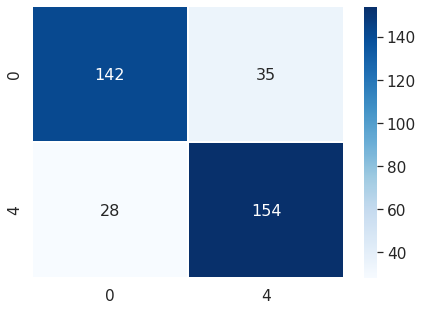

In [122]:
matrix = confusionMatrix(test,predictionTestClean)
drawMatrix(matrix)

In [123]:
check = (test[0]==predictionTestClean)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.8245125348189415


In [124]:
st = time()
predictionTrainClean,CpredTrain0,CpredTrain4 = findClasses(train[6],Cphi0,Cphi4,Ctheta0,Ctheta4,Ct0,Ct4)
print(time()-st)

16.31148052215576


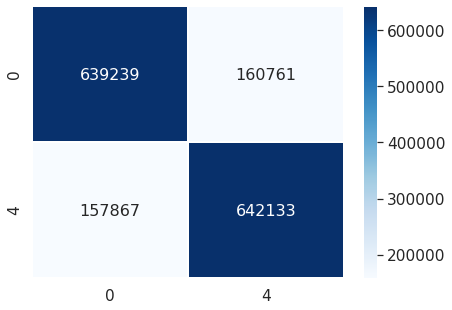

In [125]:
matrix = confusionMatrix(train,predictionTrainClean)
drawMatrix(matrix)

In [126]:
check = (train[0]==predictionTrainClean)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.8008575


# FEATURE

In [127]:
# Pass data,column of text
def getAddedVocab(train,col):
    vocab = {}
    emoji = {}
    count=0
    emojiCount=0
#     data = []
    data = train[col].unique()
    for i in range(data.shape[0]):
        x = []
#         words = train[col][i].replace(';',' ').replace("."," ").replace(","," ").split(" ")
        words = data[i].split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove('')
        for j in words:
            if(j not in vocab):
                vocab[j]=count
                count = count+1
        for j in range(0,len(words)-1):
            if(words[j]+" "+words[j+1] not in vocab):
                vocab[words[j]+" "+words[j+1]]=count
                count = count+1
        
        try:
            for j in emot.emoticons(data[i])['value']:
                if(j not in emoji):
                    emoji[j]=emojiCount
                    emojiCount = emojiCount+1
        except:
            pass

#             x.append(j)
#                 x.append(vocab[j])
#         data.append(x)
#     train[1]=data
    return vocab,emoji

In [128]:
st = time()
addedVocab,emojiVocab = getAddedVocab(train,6)
print(time()-st)
print(len(addedVocab))

89.74288511276245
4476580


In [129]:
# 0 = Negative 4 = Positive 2 = Neutral

# Pass the column of full data,column's number and vocabulary
def findAddedParamVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
#     print(v)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
#         total=total+len(i.split(" "))
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        total = total+2*len(words)-1
        for j in words:
            v[j] = v[j]+1
        for j in range(0,len(words)-1):
            v[words[j]+" "+words[j+1]] = v[words[j]+" "+words[j+1]]+1
    for key in v:
        v[key] = float(v[key]/total)
    v = {k: v for k, v in sorted(v.items(), key=lambda item: item[1],reverse=True)}
    return v,total
#     return v

# def findTotalValues(param):
#     sorted_x = {k: v for k, v in sorted(param.items(), key=lambda item: item[1])}
#     sorted_x = dict(sorted(param.items(), key=operator.itemgetter(1),reverse=True))
#     print(sorted_x[:50])

def findEmojiVocab(data,vocab,col):
    v = vocab.fromkeys(vocab,1)
#     print(v)
    total = len(vocab)
    data = data[col].unique()
    for i in data:
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
#         total = total+2*len(words)-1

        try:
            for j in emot.emoticons(data[i])['value']:
                v[j]=v[j]+1
        except:
            pass

    for key in v:
        v[key] = float(v[key]/total)
    return v,total

    
def learnAddedParam(train,vocab,emoji,col):
    m=train.shape[0]
    train4 = train[train[0]==4]
    train0 = train[train[0]==0]
    phi0 = (len(train0[col].unique()))/(m)
#     phi2 = (train[train[0]==2].shape[0]+1)/m
    phi4 = (len(train4[col].unique()))/(m)
    param0,t0 = findAddedParamVocab(train[train[0]==0],vocab,col)
    emoji0,e0 = findEmojiVocab(train[train[0]==0],emoji,col)
#     print(param0)
#     param2,t2 = findParamVocab(train[train[0]==2],vocab,col)
    param4,t4 = findAddedParamVocab(train[train[0]==4],vocab,col)
    emoji4,e4 = findEmojiVocab(train[train[0]==4],emoji,col)
#     return phi0,phi2,phi4,param0,param
    return phi0,phi4,param0,param4,t0,t4,emoji0,e0,emoji4,e4

In [130]:
st = time()
phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,e0,emoji4,e4 = learnAddedParam(train,addedVocab,emojiVocab,6)
print(time()-st)

71.99710869789124


In [131]:
# Pass the column of text
# def findClasses(data,phi0,phi1,phi2,theta0,theta2,theta4,t0,t2,t4):
def findAddedClasses(data,phi0,phi4,theta0,theta4,t0,t4,emoji0,emoji4,e0,e4):
    pred = []
    pred0 = []
    pred4 = []
    l0=[]
    count=0
    for i in theta0.keys():
        l0.append(i)
        if(count>100):
            break
        count+=1
    l4=[]
    count=0
    for i in theta4.keys():
        l4.append(i)
        if(count>100):
            break
        count+=1
    
    for i in data:
        prob0 = 0
        prob4 = 0
        words = i.split(" ")
        while " " in words:
            words.remove(" ")
        while "" in words:
            words.remove("")
        count0=1
        count4=1
        for j  in words:
            if j in l0:
                count0+=1
            try:
                prob0 = prob0+(math.log(theta0[j]))
            except:
                prob0 = prob0+float(1/(t0+1))
            if j in l4:
                count4+=1
            try:
                prob4 = prob4+(math.log(theta4[j]))
            except:
                prob4 = prob4+float(1/(t4+1))
                
        for j in range(0,len(words)-1):
            try:
                prob0 = prob0+(math.log(theta0[words[j]+" "+words[j+1]]))
            except:
                prob0 = prob0+float(1/(t0+1))
            try:
                prob4 = prob4+(math.log(theta4[words[j]+" "+words[j+1]]))
            except:
                prob4 = prob4+float(1/(t4+1))
        
        flag=0
        try:
            for j in emot.emoticons(i)['value']:
                flag=1
                prob0=prob0+math.log(emoji0[j])
                prob4=prob4+math.log(emoji4[j])
        except:
            pass
    
        if(flag==0):
            prob0 = prob0+float(1/(e0+1))
            prob4 = prob4+float(1/(e4+1))
        
        
        prob0 = prob0+(math.log(phi0))+(count0/101)
#         prob2 = prob2+(math.log(phi2))
        prob4 = prob4+(math.log(phi4))+(count4/101)
        if(prob0>prob4):
            pred.append(0)
#         elif(prob2>prob0 and prob2>prob4):
#             pred.append(2)
        else:
            pred.append(4)
        pred0.append(prob0)
        pred4.append(prob4)
    return pred,pred0,pred4

In [132]:
st = time()
# predictionTrain = findClasses(train[5],phi0,phi2,phi4,theta0,theta2,theta4,t0,t2,t4)
predictionAddedTrain,predAdded0,predAdded4 = findAddedClasses(train[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print(time()-st)

126.84330916404724


In [133]:
check = (train[0]==predictionAddedTrain)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.90364125


In [134]:
st = time()
test = test[test[0]==0].append(test[test[0]==4])
predictionAddedTest,predAddedTest0,predAddedTest4 = findAddedClasses(test[6],phiF0,phiF4,thetaF0,thetaF4,tF0,tF4,emoji0,emoji4,e0,e4)
print(time()-st)

0.2455306053161621


In [135]:
check = (test[0]==predictionAddedTest)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.841225626740947


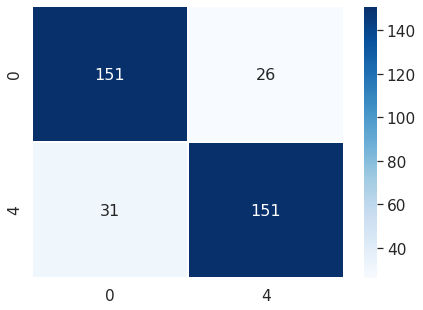

In [136]:
matrix = confusionMatrix(test,predictionAddedTest)
drawMatrix(matrix)

# TF-IDF

In [137]:
tfidf = TfidfVectorizer(min_df=0.0007)
clf = GaussianNB()
multi = MultinomialNB()

In [138]:
train

,0,1,2,3,4,5,6
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",http://twitpic com/2y1zl - awww bummer shou...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat hi facebook text might cri resu...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,dive mani time ball manag save 50% rest go b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",behav I mad whi here? becaus see
...,...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,woke school best feel ever
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdb com - veri cool hear old walt interview...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,readi mojo makeover? ask detail
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happi 38th birthday boo alll time tupac ama...


In [139]:
st=time()
X = tfidf.fit_transform(train[6])
print(time()-st)

12.670225858688354


In [140]:
X.shape

(1600000, 1328)

In [141]:
def tfidfVectorizer(clf,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        clf.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return clf

def tfidfMultiVectorizer(multi,X,data):
    for i in tqdm(range(0,data.shape[0]//1000)):
        multi.partial_fit(X[1000*i:1000*(i+1)].todense(),data[0][1000*i:1000*(i+1)],classes=np.array([0,4]))
    return multi

In [142]:
clf = tfidfVectorizer(clf,X,train) 

100%|██████████| 1600/1600 [00:21<00:00, 73.96it/s]


In [54]:
# multi = tfidfMultiVectorizer(multi,train)
# filename = 'tfidfClf.sav'
# pickle.dump(clf, open(filename, 'wb'))
loaded_model = pickle.load(open("tfidfClf.sav", 'rb'))

In [143]:
demo = MultinomialNB()
demo.fit(X,train[0])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [144]:
st=time()
Y = tfidf.transform(test[6])
testDense = Y.todense()
print(time()-st)

0.03287768363952637


In [145]:
testDense.shape

(359, 1328)

In [146]:
predictionTestTfidf = clf.predict(testDense)

In [147]:
check = (test[0]==predictionTestTfidf)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.8105849582172702


In [148]:
predMulti = demo.predict(Y)
check = (test[0]==predMulti)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.8050139275766016


In [154]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train[6])

In [155]:
Y = train[0]
percentile = SelectPercentile(chi2, percentile=10)
selectedData = percentile.fit_transform(X,Y)

In [156]:
clf2 = GaussianNB()
per10 = tfidfVectorizer(clf2,selectedData,train)

100%|██████████| 1600/1600 [09:33<00:00,  2.79it/s]


In [151]:
st=time()
Y = tfidf.transform(test[6])
testDense = Y.todense()
testDense10per = percentile.transform(testDense)
print(time()-st)

0.13982796669006348


In [152]:
prediction10per = clf2.predict(testDense10per)

In [153]:
check = (test[0]==prediction10per)
t=0
f=0
for i in check:
    if i:
        t=t+1
    else:
        f=f+1
print(t/(t+f))

0.713091922005571


# G

In [123]:
def rocCurve(data,prob0,prob4):
    y = label_binarize(data[0],classes=[0,4])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y,prob0)
    roc_auc[0] = auc(fpr[0], tpr[0])
    fpr[1], tpr[1], _ = roc_curve(y,prob4)
    roc_auc[1] = auc(fpr[1], tpr[1])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve for Class 0(area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], color='cyan',lw=lw, label='ROC curve for Class 1(area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

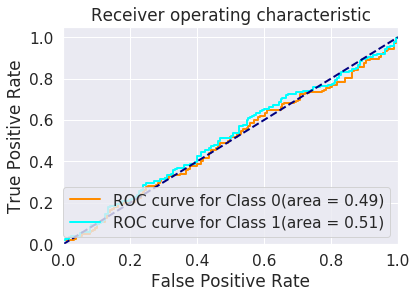

In [125]:
# probGaussian = loaded_model.predict_log_proba(testDense)
# probMulti = demo.predict_log_proba(Y)
# rocCurve(test,probGaussian[:,0],probGaussian[:,1])
rocCurve(test,CpredTest0,CpredTest4)